In [1]:
from PIL import Image
import numpy as np
import cv2
import os

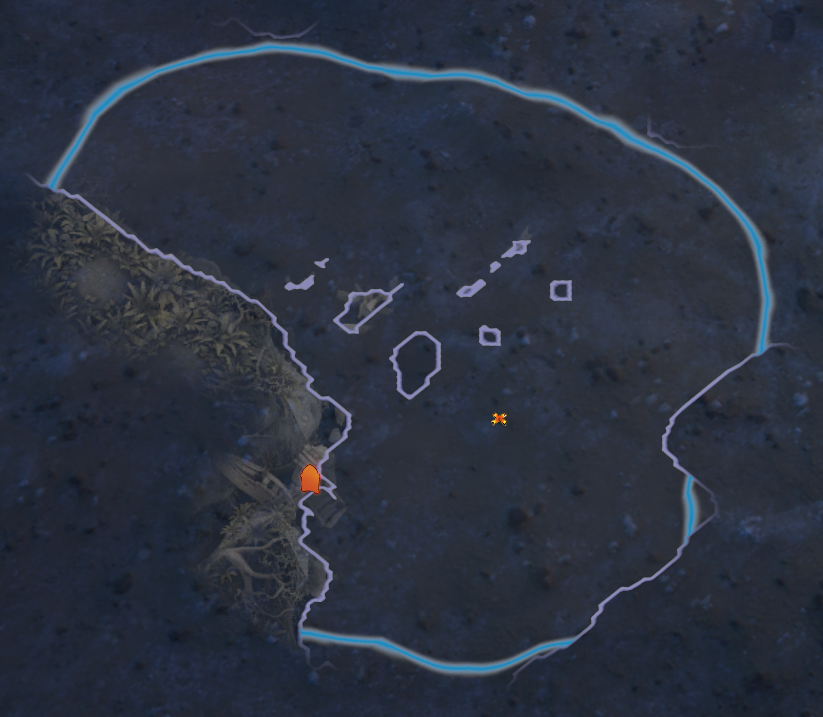

In [2]:
"""
We want to train a model to take any game screenshot and extract only the map features.
This is what people do when they look at the screen.

To assemble training data, we start by taking a screenshot in game, manually crop the image 
with MS paint to a smaller area that only contains the map information, with minimal stuff 
in the background.

The blue map lines seem like their colors can be distored by background interference 
(e.g. fires), which we minimize with this manual crop. Then we can just use color filters to
extract the map lines.

These extracted map lines are ground truth. The other screenshots in our model training data
have the same lines, but overlayed on much noisier backgrounds. The model will learn to 
convert the noisy screenshots to the clean map features.
"""
manual_crop = Image.open("data/manual_crop/0.png")
# remove alpha channel added while cropping with ms paint
display(manual_crop)
manual_crop = np.array(manual_crop)[:,:,0:3]

In [3]:
def filter_color_ranges(image, ranges):
    """
    Filter an image to keep only pixels within specified color ranges.
    
    :param image: NumPy array of shape (height, width, 3) with values 0-255
    :param ranges: List of tuples, each containing min and max values for R, G, and B
    :return: Filtered image with pixels outside the ranges set to black
    """
    # Create a copy of the image
    filtered_image = image.copy()
    
    # Create a mask initialized with all False
    mask = np.zeros(image.shape[:2], dtype=bool)
    
    # For each color range, update the mask
    for (r_min, r_max), (g_min, g_max), (b_min, b_max) in ranges:
        range_mask = (
            (image[:,:,0] >= r_min) & (image[:,:,0] <= r_max) &
            (image[:,:,1] >= g_min) & (image[:,:,1] <= g_max) &
            (image[:,:,2] >= b_min) & (image[:,:,2] <= b_max)
        )
        mask |= range_mask
    
    # Apply the mask: set pixels outside the ranges to black
    filtered_image[~mask] = [0, 0, 0]
    
    return filtered_image

In [4]:
def get_mask(image):
    # Define color ranges: (R_min, R_max), (G_min, G_max), (B_min, B_max)
    bluish_range = ((110, 150), (0, 150), (150, 255))
    color_ranges = [bluish_range]
    map_lines = filter_color_ranges(image, color_ranges)
    mask = np.any(map_lines > 0, axis=2).astype(np.uint8)
    return mask

In [5]:
# Extract door subsection which is anchor point for aligning and cropping screenshots

def largest_true_subsection(arr):
    if not arr.any():
        return (0, 0, 0, 0)  # No True values
    
    rows, cols = arr.shape
    heights = np.zeros(cols, dtype=int)
    max_area = 0
    max_rect = (0, 0, 0, 0)  # (top, left, height, width)

    for row in range(rows):
        heights = (heights + 1) * arr[row]
        stack = [-1]
        
        for col in range(cols + 1):
            h = heights[col] if col < cols else 0
            while stack[-1] != -1 and heights[stack[-1]] > h:
                height = heights[stack.pop()]
                width = col - stack[-1] - 1
                area = height * width
                if area > max_area:
                    max_area = area
                    max_rect = (row - height + 1, stack[-1] + 1, height, width)
            stack.append(col)

    return max_rect

def extract_subsection(arr, subsection):
    top, left, height, width = subsection
    return arr[top:top+height, left:left+width]
    
def extract_door_subsection(image):
    # Turn all pixels black except door
    orangeish_range = ((180, 220), (80, 125), (35, 45))  # More red, some green, little blue
    color_ranges = [orangeish_range]
    door = filter_color_ranges(image, color_ranges)
    # crop the door
    # Convert to grayscale
    gray = cv2.cvtColor(door, cv2.COLOR_RGB2GRAY)
    # Threshold the image to create a binary mask
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find the bounding rectangle of the icon
    x, y, w, h = cv2.boundingRect(contours[0])
    # Crop the icon
    door = door[y:y+h, x:x+w]
    mask = np.all(door != 0, axis=-1)
    subsection = largest_true_subsection(mask)
    return extract_subsection(door, subsection)

def auto_crop_ss(ss, manual_crop):
    door_subsection = extract_door_subsection(manual_crop)
    # Convert RGB to BGR for OpenCV processing
    manual_crop_bgr = cv2.cvtColor(manual_crop, cv2.COLOR_RGB2BGR)
    door_subsection_bgr = cv2.cvtColor(door_subsection, cv2.COLOR_RGB2BGR)
    # Automatically crop the source image to the same size as the manually cropped image,
    # with perfect overlap of the door subsection between the two images
    image_bgr = cv2.cvtColor(ss, cv2.COLOR_RGB2BGR)
    method = cv2.TM_CCOEFF_NORMED
    res1 = cv2.matchTemplate(manual_crop_bgr, door_subsection_bgr, method)
    res2 = cv2.matchTemplate(image_bgr, door_subsection_bgr, method)
    
    _, _, _, max_loc1 = cv2.minMaxLoc(res1)
    _, _, _, max_loc2 = cv2.minMaxLoc(res2)
    
    shift_x = max_loc2[0] - max_loc1[0]
    shift_y = max_loc2[1] - max_loc1[1]
    
    # Get dimensions
    h1, w1 = ss.shape[:2]
    h2, w2 = manual_crop.shape[:2]
    
    x1 = max(0, shift_x)
    y1 = max(0, shift_y)
    x2 = min(w1, w2 + shift_x)
    y2 = min(h1, h2 + shift_y)
    
    cropped_overlap = ss[y1:y2, x1:x2]
    return cropped_overlap

In [ ]:
num_groups = 1
for group in range(num_groups):
    manual_crop = Image.open(f"data/manual_crop/{group}.png")
    # remove alpha channel added while cropping with ms paint
    manual_crop = np.array(manual_crop)[:,:,0:3]

    # Extract ground truth mask
    truth_mask = get_mask(manual_crop)
    np.savez_compressed(f"data/mask/{group}.npz", data=truth_mask)
    
    ss_dir = f"data/screenshot/{group}"
    out_dir = f"data/auto_crop/{group}"
    os.makedirs(out_dir)
    for i, ss in enumerate(sorted(os.listdir(ss_dir))):
        ss = np.array(Image.open(os.path.join(ss_dir, ss)))
        crop = auto_crop_ss(ss, manual_crop)
        #display(Image.fromarray(crop))
        filename = os.path.join(out_dir, f"{i}.npz")
        np.savez_compressed(filename, data=crop)
        #filename = os.path.join(out_dir, f"{i}.png")
        #Image.fromarray(crop).save(filename, format='PNG', compress_level=0)
        if i % 10 == 0:
            print(filename)

In [ ]:
mask = np.load("data/mask/0.npz")['data']
display(Image.fromarray(mask * 255, mode="L"))

crop = np.load("data/auto_crop/0/0.npz")['data']
display(Image.fromarray(crop))

In [10]:
door = extract_door_subsection(manual_crop)
display(Image.fromarray(door))
np.savez_compressed("data/door.npz", data=door)